In [ ]:
import glob
from music21 import converter, instrument, note, chord, stream
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
from tensorflow.keras.preprocessing.text import Tokenizer
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir tracks
for i in range(24944, 24992):
  req = requests.get("https://bitmidi.com/uploads/%d.mid" % i)
  open('tracks/%d.mid' % i, 'wb').write(req.content)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import glob
from music21 import converter, instrument, note, chord, stream
notes = []
for file in glob.glob("tracks/*.mid"):
  midi = converter.parse(file)
  notes_to_parse = None
  try:
    s2 = instrument.partitionByInstrument(midi)
    notes_to_parse = s2.parts[0].recurse()
  except:
    notes_to_parse = midi.flat.notes
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      notes.append(".".join(str(n) for n in element.normalOrder))
  # print(notes)

  

In [ ]:
print(len(notes))

44543


In [ ]:
SEQUENCE_LENGTH = 200
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler((-1, 1))
def generate_sequences(notes):
  sorted_pitches = sorted(set(item for item in notes))
  pitch_dict = dict((note, number) for number, note in enumerate(sorted_pitches))
  sequences = [pitch_dict[x] for x in notes]
  sequence_group = []
  for i in range(SEQUENCE_LENGTH, len(sequences) + 1):
    new_sequence = sequences[i-SEQUENCE_LENGTH:i]
    sequence_group.append(new_sequence)
  sequence_group = np.array(sequence_group)
  sequence_group = minMaxScaler.fit_transform(sequence_group)
  return sequence_group



In [ ]:
sequences = generate_sequences(notes)

In [ ]:
BATCH_SIZE=64
dset = data.TensorDataset(torch.from_numpy(sequences).to(device))
dataloader = data.dataloader.DataLoader(dset, batch_size=BATCH_SIZE)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, num_layers=3)
    self.linear1 = nn.Linear(128, 64)
    self.linear2 = nn.Linear(64, 1)
  def forward(self, x):
    x = x.to(device)
    x, (self.h, self.c) = self.lstm1(x)
    x = self.h[-1, :, :]
    x = F.leaky_relu(self.linear1(x))
    x = torch.sigmoid(self.linear2(x))
    return x
    



In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.linear1 = nn.Linear(100, 64)
    self.bn1 = nn.BatchNorm1d(64)
    self.linear2 = nn.Linear(64, 128)
    self.bn2 = nn.BatchNorm1d(128)
    self.linear3 = nn.Linear(128, 256)
    self.bn3 = nn.BatchNorm1d(256)
    self.linear4 = nn.Linear(256, 512)
    self.bn4 = nn.BatchNorm1d(512)
    self.linear5 = nn.Linear(512, 200)
  def forward(self, x):
    x = x.to(device)
    x = self.bn1(F.leaky_relu(self.linear1(x)))
    x = self.bn2(F.leaky_relu(self.linear2(x)))
    x = self.bn3(F.leaky_relu(self.linear3(x)))
    x = self.bn4(F.leaky_relu(self.linear4(x)))
    x = torch.tanh(self.linear5(x))
    return x


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss().to(device)
optimizerDiscriminator = optim.Adam(discriminator.parameters())
optimizerGenerator = optim.Adam(generator.parameters())

In [ ]:
discriminator_loss_over_time = []
generator_loss_over_time = []
discriminator_fake_loss_over_time = []

In [ ]:
with open("drive/My Drive/MusicGenerator2/genloss.txt", "r") as f:
  for line in f:
    r = line[:-1]
    generator_loss_over_time.append(float(r))
with open("drive/My Drive/MusicGenerator2/dislossreal.txt", "r") as f:
  for line in f:
    r = line[:-1]
    discriminator_loss_over_time.append(float(r))
with open("drive/My Drive/MusicGenerator2/dislossfake.txt", "r") as f:
  for line in f:
    r = line[:-1]
    discriminator_fake_loss_over_time.append(float(r))

470.0
475.0
380.0
434.0
445.0
458.0
467.0
478.0
467.0
480.0
467.0
469.0
416.0
452.0
464.0
470.0
474.0
478.0
471.0
476.0


In [ ]:
d_state_dict = torch.load("drive/My Drive/MusicGenerator2/discriminatorColdplay480")
discriminator.load_state_dict(d_state_dict)
g_state_dict = torch.load("drive/My Drive/MusicGenerator2/generatorColdplay480")
generator.load_state_dict(g_state_dict)
optim_d_state_dict = torch.load("drive/My Drive/MusicGenerator2/optimDiscriminatorColdplay480")
optimizerDiscriminator.load_state_dict(optim_d_state_dict)
optim_g_state_dict = torch.load("drive/My Drive/MusicGenerator2/optimGeneratorColdplay480")
optimizerGenerator.load_state_dict(optim_g_state_dict)


Epoch 340, Cumulative_Loss_Generator: 501.9825, Cumulative_Loss_Discriminator: 475.2989, Average_Loss_Generator: 0.7244 Average_Loss_Discriminator: 0.6859
Epoch 341, Cumulative_Loss_Generator: 543.8485, Cumulative_Loss_Discriminator: 458.5389, Average_Loss_Generator: 0.7848 Average_Loss_Discriminator: 0.6617
Epoch 342, Cumulative_Loss_Generator: 634.3684, Cumulative_Loss_Discriminator: 450.8678, Average_Loss_Generator: 0.9154 Average_Loss_Discriminator: 0.6506
Epoch 343, Cumulative_Loss_Generator: 510.4715, Cumulative_Loss_Discriminator: 468.9289, Average_Loss_Generator: 0.7366 Average_Loss_Discriminator: 0.6767
Epoch 344, Cumulative_Loss_Generator: 532.5328, Cumulative_Loss_Discriminator: 477.2172, Average_Loss_Generator: 0.7684 Average_Loss_Discriminator: 0.6886
Epoch 345, Cumulative_Loss_Generator: 482.1381, Cumulative_Loss_Discriminator: 480.1215, Average_Loss_Generator: 0.6957 Average_Loss_Discriminator: 0.6928
Epoch 346, Cumulative_Loss_Generator: 500.2009, Cumulative_Loss_Discri

KeyboardInterrupt: ignored

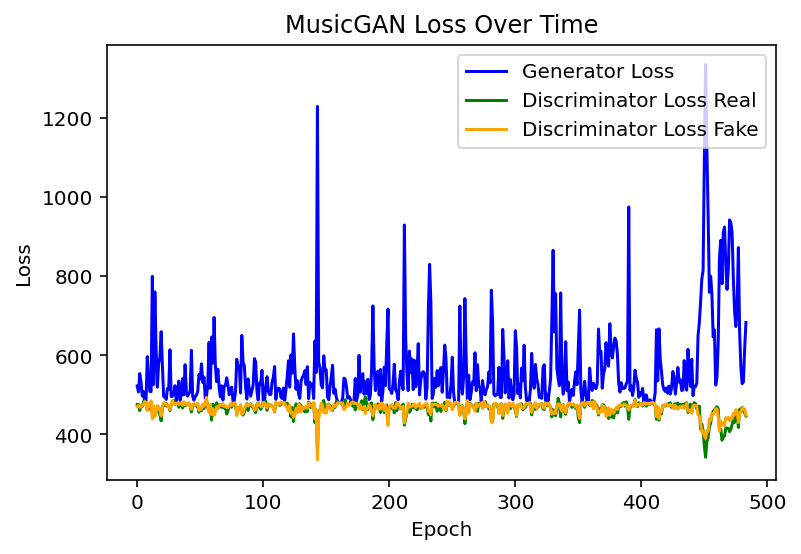

In [ ]:
generator_loss_over_time = []
discriminator_loss_over_time = []
discriminator_fake_loss_over_time = []
NOISE_LENGTH =100
lossDEpoch = 0
lossGEpoch = 0
lossDFake = 0
for epoch in range(339, 1500):
  global lossDEpoch, lossGEpoch, lossDFake
  lossDEpoch = 0
  lossGEpoch = 0
  lossDFake = 0
  for i, d in enumerate(dataloader):
    ## Updating Discriminator Network ##
    # 1. Zero Gradient
    optimizerDiscriminator.zero_grad()
    optimizerGenerator.zero_grad()
    # 2. Take the data tensor from dataloader
    real_songs = d[0].to(device)
    # 3. Reshape Data to be compatible for Discriminator Network (SEQUENCE_LENGTH, BATCH_SIZE, HIDDEN_FEATURES)
    real_songs = Variable(torch.reshape(real_songs, (200, d[0].shape[0], 1))).to(device)
    # 4. Get Output From Discriminator
    outputD = discriminator(real_songs.float().to(device))
    # 5. Create Target Tensor of Ones to be same shape as Output of Discriminator (BATCH_SIZE, 1)
    target = torch.ones((real_songs.shape[1], 1)).to(device)
    # 6. Compute BCE Loss
    lossReal = criterion(outputD, target)
    # 7. Generate Noise for Generator Network
    noise = Variable(torch.randn((d[0].shape[0], NOISE_LENGTH)))
    fake_songs = generator(noise)
    # 8. Reshape Output of Generator to be compatible for Discriminator Network (SEQUENCE_LENGTH, BATCH_SIZE, HIDDEN_FEATURES)
    fake_songs = torch.reshape(fake_songs, (200, d[0].shape[0] , 1)).to(device)
    # 9. Create Target Tensor of Zeros to be same shape as Output of Discriminator (BATCH_SIZE, 1)
    target = torch.zeros((fake_songs.shape[1], 1)).to(device)
    outputD = discriminator(fake_songs.detach())
    lossFake = criterion(outputD, target)
    lossD = lossFake + lossReal
    lossD.backward()
    optimizerDiscriminator.step()

    outputD = discriminator(fake_songs)
    target = torch.ones((fake_songs.shape[1], 1)).to(device)
    lossG = criterion(outputD, target)
    lossG.backward()

    lossDEpoch += lossReal.item()
    lossGEpoch += lossG.item()
    lossDFake += lossFake.item()

    optimizerGenerator.step()
  generator_loss_over_time.append(lossGEpoch)
  discriminator_loss_over_time.append(lossDEpoch)
  discriminator_fake_loss_over_time.append(lossDFake)
  plt.clf()
  plt.plot(generator_loss_over_time, label="Generator Loss", color="blue")
  plt.plot(discriminator_loss_over_time, label="Discriminator Loss Real", color="green")
  plt.plot(discriminator_fake_loss_over_time, label="Discriminator Loss Fake", color="orange")
  plt.xlabel("Epoch")
  plt.legend()
  plt.title("MusicGAN Loss Over Time")
  plt.ylabel("Loss")
  plt.savefig("drive/My Drive/MusicGenerator2/loss.jpg")
  if epoch % 10 == 0:
      torch.save(generator.state_dict(), "drive/My Drive/MusicGenerator2/generatorColdplay%d" % epoch)
      torch.save(discriminator.state_dict(), "drive/My Drive/MusicGenerator2/discriminatorColdplay%d" % epoch)
      torch.save(optimizerGenerator.state_dict(), "drive/My Drive/MusicGenerator2/optimGeneratorColdplay%d" % epoch)
      torch.save(optimizerDiscriminator.state_dict(), "drive/My Drive/MusicGenerator2/optimDiscriminatorColdplay%d" % epoch)
  with open("drive/My Drive/MusicGenerator2/genloss.txt", "w") as f:
    for r in generator_loss_over_time:
      f.write("%d\n" % r)
  with open("drive/My Drive/MusicGenerator2/dislossreal.txt", "w") as f:
    for r in discriminator_loss_over_time:
      f.write("%d\n" % r)
  with open("drive/My Drive/MusicGenerator2/dislossfake.txt", "w") as f:
    for r in discriminator_fake_loss_over_time:
      f.write("%d\n" % r)

  print("Epoch %d, Cumulative_Loss_Generator: %.4f, Cumulative_Loss_Discriminator: %.4f, Average_Loss_Generator: %.4f Average_Loss_Discriminator: %.4f" % (epoch + 1, lossGEpoch, lossDEpoch, lossGEpoch/len(dataloader), lossDEpoch/len(dataloader)))









In [ ]:
torch.save(generator.state_dict(), "drive/My Drive/MusicGenerator2/generatorColdplay%d" % epoch)
torch.save(discriminator.state_dict(), "drive/My Drive/MusicGenerator2/discriminatorColdplay%d" % epoch)
torch.save(optimizerGenerator.state_dict(), "drive/My Drive/MusicGenerator2/optimGeneratorColdplay%d" % epoch)
torch.save(optimizerDiscriminator.state_dict(), "drive/My Drive/MusicGenerator2/optimDiscriminatorColdplay%d" % epoch)

In [ ]:
def create_midi(prediction_output, filename):
  offset = 0
  output_notes = []
  for item in prediction_output:
    pattern = item[0]
    if ("." in pattern) or pattern.isdigit():
      notes_in_chord = pattern.split(".")
      notes = []
      for current_note in notes_in_chord:
        new_note = note.Note(int(current_note))
        notes.append(new_note)
      new_chord = chord.Chord(notes)
      new_chord.offset = offset
      output_notes.append(new_chord)
    else:
      new_note = note.Note(pattern)
      new_note.offset = offset
      new_note.storedIntrument = instrument.Piano()
      output_notes.append(new_note)
    offset += 0.5
  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp="{}.mid".format(filename))






In [ ]:
with open("drive/My Drive/MusicGenerator/genloss.txt", "w") as f:
  for r in generator_loss_over_time:
    f.write("%d\n" % r)
with open("drive/My Drive/MusicGenerator/disloss.txt", "w") as f:
  for r in discriminator_loss_over_time:
    f.write("%d\n" % r)


In [ ]:
sorted_pitches = sorted(set(item for item in notes))
pitch_dict = dict((number, note) for number, note in enumerate(sorted_pitches))

In [ ]:
sample_noise = torch.randn((64, 100))
output = generator(sample_noise)
import random
print(output[63].cpu().detach().numpy())

final_note_list = []
output = output[0].cpu().detach().numpy().reshape((1, 200))
output = minMaxScaler.inverse_transform(output)
print(output)
for x in output[0]:
  final_note_list.append(pitch_dict[random.randint(0, 63)])


[ 0.664136    0.2896312   0.66106194 -0.9999592   0.7903309   0.9970879
  0.6652756   0.9942043   0.51020175  0.8242581  -0.00754637 -0.54229724
 -0.07677719  0.9134239   0.6516689   0.7397678   0.72970605  0.21909003
  0.7832627  -0.9980237  -0.24038582  0.9697548  -0.14793457  0.91379166
  0.6999518   0.60412407  0.00787012 -0.29406992 -0.84161353  0.96138835
 -0.25042582  0.9173628   0.7458098  -0.152676   -0.9999671   0.998185
 -0.79075736 -0.77204776  0.59062946  0.489503    0.73789644  0.07447355
  0.06074766  0.72737676  0.19760677 -0.7967748  -0.10097427  0.91524535
  0.68559676  0.53095895  0.09629031 -0.20521948  0.04757069  0.5455931
  0.8377763   0.58589494  0.79844457  0.8628401  -0.14444664 -0.9968936
 -0.12931821  0.84460825  0.86211205  0.7048192   0.51238185 -0.66901124
  0.48277172  0.40026647  0.9643506   0.99787253 -0.93592626  0.98076427
 -0.8195192   0.7506297   0.99971277 -0.99643147  0.95465237  0.9871766
 -0.46929774  0.8530081  -0.96151674  0.99031186  0.99951

In [ ]:
create_midi(final_note_list, "track")

200
